In [1]:
%reset -f
import numpy as np
import pandas as pd


import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
path  = r'/rfs/CAPAI_PhD_dflr2/dflr2/Codes_Data_2/Data/'
file9 = path + '20210525_spin.txt'
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')
df_spin['date_time_arrived'] = pd.to_datetime(df_spin['date_time_arrived'], format='%Y-%m-%d %H:%M:%S')

In [3]:
df_spin.head(4)

,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
0,22377059,2016-01-05 12:27:00,Y,Y,2015-01-05,15:35,Y,N,Y,2.000,Y,NaN,N,2016-01-05 12:50:00\r
1,83768183,2016-01-06 13:00:00,Y,Y,2016-01-06,14:53,Y,N,Y,0.000,Y,NaN,Y,2016-01-06 16:00:00\r
2,14436193,2016-01-06 18:59:00,Y,Y,2016-01-06,19:50,Y,N,Y,0.000,Y,NaN,Y,2016-01-06 18:00:00\r
3,18703762,2016-01-06 11:30:00,Y,Y,2016-01-06,12:24,Y,N,Y,0.000,Y,NaN,Y,2016-01-06 12:40:00\r


In [4]:
len(df_spin['patient_id'].unique())

6078

In [5]:
############################################################
# LOADING ADMISSIONS AND PATIENTS DF
############################################################
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2016_2018.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]


In [6]:
df_admissions.head(4)

,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score
0,3305648,"||J18.9,K59.0,L89.1,I10.X,E11.9,H91.9,D50.8,Z73.9",68825097,89,2016-08-16 23:58:00,17029.999,2016-08-17 15:37:00,17030.651,0 days 15:39:00,1,0,0,1
1,7763466,"||J18.1,J84.9,C34.9,R26.8,E11.9,R15.X,R32.X,H91.9",68825097,90,2017-10-26 05:36:00,17465.233,2017-10-26 17:59:00,17465.749,0 days 12:23:00,1,0,0,3
2,58250780,"||J18.1,J44.0,C34.9,I71.4,R60.0,I73.9,Z92.1,I1...",68825097,91,2017-11-06 23:01:00,17476.959,2017-11-09 05:50:00,17479.243,2 days 06:49:00,1,1,0,4
3,92255436,"||J15.4,J84.9,K21.9,E03.9,E55.9,F06.7,M19.9||J...",86629350,84,2016-06-08 21:12:00,16960.883,2016-06-22 14:45:00,16974.615,13 days 17:33:00,1,1,0,0


# Filtering Data

In [7]:
list_patients = df_spin[~(df_spin['curb65_score'].isna())]['patient_id'].unique()

print('number of patients with Curb65 information', len(list_patients))
print('number of admissions in df', len(df_admissions[df_admissions['patient_id'].isin(list_patients)]))

number of patients with Curb65 information 5348
number of admissions in df 7940


In [8]:
df_spin[df_spin['patient_id'] == 68825097]

,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
1005,68825097,2016-08-16 12:50:00,Y,Y,2016-08-16,16:36,Y,N,Y,2.000,N,NaN,N,2016-08-16 18:30:00\r


In [9]:
df_ = []

def pruebas(temp_spin, temp_admn, dt):
    ls = []
    for idx,curb_record in temp_spin.iterrows():
        time_crb  = curb_record['date_time_arrived']
        curb = curb_record['curb65_score']
        #dt        = datetime.timedelta(days=1)
        admn_cand = temp_admn[(temp_admn['admission_date_time'] < (time_crb + dt) ) &
                              (temp_admn['discharge_date_time'] > (time_crb - dt) ) ]
        if len(admn_cand) == 0: 
            continue
        if len(admn_cand) == 1:
            admn = admn_cand['admission_id'].iloc[0]
            age  = admn_cand['age_at_admission\r'].iloc[0]
            los  = admn_cand['lengthofstay'].iloc[0]
            los_d = los.days + round((los.seconds/(60*60*24))*2)/2
            ls.append([admn, patient, curb, age, los_d])
        else:
            #print('puta')
            ls = pruebas(temp_spin, temp_admn, datetime.timedelta(days=0.1))
            return(ls)
            break
    return ls
error = 0
for patient in list_patients:
    temp_spin = df_spin[df_spin['patient_id'] == patient]
    temp_admn = df_admissions[df_admissions['patient_id'] == patient]
    a =1
    if temp_admn['mortal_admin'].iloc[0] == 1:
        admin_date = temp_admn['admission_date_time'].iloc[0]
        death_date = df_patients[df_patients['patient_id'] == patient].iloc[0]['date_of_death']
        time_to_death = death_date - admin_date
        # Length to death
        ltd = time_to_death.days + round((time_to_death.seconds/(60*60*24))*2)/2
    else:
        ltd = 101
    if (len(temp_spin) == 1) and (len(temp_admn) ==1):
        curb = temp_spin['curb65_score'].iloc[0]
        
        #curb = 0 if curb < 2 else 2 if curb > 2 else 1
        los  = temp_admn['lengthofstay'].iloc[0]
        age  = temp_admn['age_at_admission\r'].iloc[0]
        admn = temp_admn['admission_id'].iloc[0]
        los_d = los.days + round((los.seconds/(60*60*24))*2)/2
        mort = temp_admn['mortal_admin'].iloc[0]
        
        df_.append([admn, patient, curb, age, los_d, ltd, mort])
    else:
        ls = pruebas(temp_spin, temp_admn, datetime.timedelta(days=1.5))
        
        if len(ls) == 0:
            error = error +1 
            #break
print('number of errors:', error)                

number of errors: 59


In [10]:
df = pd.DataFrame(df_, columns =['admission', 'patient', 'curb','age','los', 'ltd', 'mortality'])
df.head(5)

,admission,patient,curb,age,los,ltd,mortality
0,9436266,22377059,2.000,67,0.000,101.000,0
1,76234339,83768183,0.000,45,0.000,101.000,0
2,49526628,18703762,0.000,50,0.000,101.000,0
3,83178038,31951825,3.000,72,3.000,101.000,0
4,86923643,72115537,2.000,88,1.000,101.000,0


<AxesSubplot:>

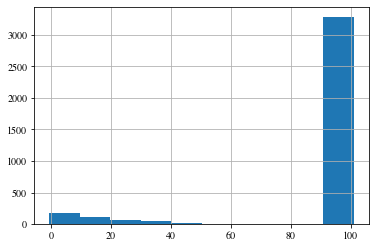

In [11]:
df['ltd'].hist()

In [12]:
list_mortal_admins = df_admissions[df_admissions['mortal_admin'] == 1]['admission_id'].unique()
print('total admins in survival analysis',len(df))
print('admins where patient deceased',len(df[df['admission'].isin(list_mortal_admins )]))



total admins in survival analysis 3711
admins where patient deceased 432


# CURB

<AxesSubplot:xlabel='timeline'>

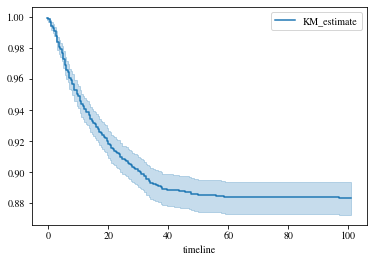

In [13]:
from lifelines import KaplanMeierFitter

T = df[~df['ltd'].isna()]['ltd']
E = df[~df['ltd'].isna()]['mortality']

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

Text(0.5, 1.0, 'Survival of different gender group')

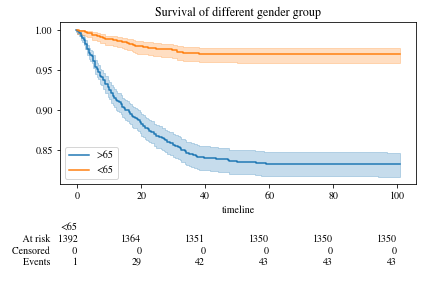

In [14]:
ax = plt.subplot(111)
m = (df["age"] > 65)
kmf.fit(durations = T[m], event_observed = E[m], label = ">65")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "<65")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title("Survival of different gender group")

In [15]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df, duration_col = 'ltd', event_col = 'mortality')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3711 total observations, 3279 right-censored observations>
             duration col = 'ltd'
                event col = 'mortality'
      baseline estimation = breslow
   number of observations = 3711
number of events observed = 432
   partial log-likelihood = -3293.20
         time fit was run = 2023-11-24 13:26:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
admission   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
patient    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
curb        0.45       1.57       0.05             0.35             0.55                 1.42                 1.74
age         0.05       1.05       0.00             0.04             0.05                 1.04                 1.06
los         0.02       1.02       0.00             0.01             0.03                 1.01                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
admission     0.00  1.82   0.07       3.87
patient       0.00 -2.40   0.02       5.91
curb          0.00  8.57 <0.005      56.47
age           0.00  9.24 <0.005      65.08
los           0.00  5.40 <0.005      23.84
---
Concordance = 0.78
Partial AIC = 6596.41
log-likelihood ratio test = 462.62 on 5 df
-log2(p) of ll-ratio test = 322.33

In [16]:
cph.hazard_ratios_


covariate
admission   1.000
patient     1.000
curb        1.571
age         1.046
los         1.020
Name: exp(coef), dtype: float64

In [17]:
dict_df_curb = {}

int_days = 25

columns = ['time_days','curb_0', 'curb_1','curb_2','curb_3','curb_4', 'curb_5']
columns = ['time_days','curb_0', 'curb_1','curb_2']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_curb[columns[0]] = time
for i in range(len(columns)-1):
    df_temp = df[df['curb']==i]
    tot_pat = len(df_temp)
    df_temp_mort = df_temp[~df_temp['ltd'].isna()]
    
    ls_curb = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
    dict_df_curb[columns[i+1]] = ls_curb 
df_curb = pd.DataFrame(dict_df_curb)

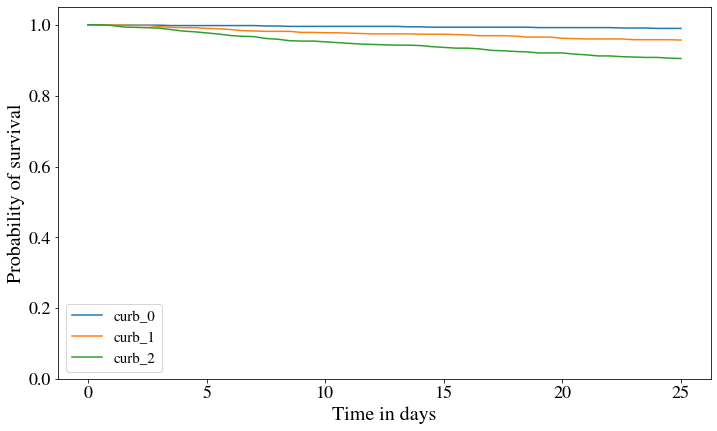

In [18]:
plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_curb[columns[0]], df_curb[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
#plt.savefig('Survival_analysis_Curb_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()


dict_df_curb = {}


int_days = 15

columns = ['time_days','curb_0', 'curb_1','curb_2','curb_3','curb_4', 'curb_5']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_curb[columns[0]] = time
for i in range(6):
    df_temp = df[df['curb']==i]
    
    ls_curb = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
    dict_df_curb[columns[i+1]] = ls_curb 
df_curb = pd.DataFrame(dict_df_curb) 



plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_curb[columns[0]], df_curb[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Curb_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()

# AGE

In [19]:
dict_df_age = {}


int_days = 20

columns = ['time_days','<=65', '>65']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_age[columns[0]] = time

df_temp = df[(df['age']<=65)]
tot_pat = len(df_temp)
df_temp_mort = df_temp[~df_temp['ltd'].isna()]
ls_age = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
#ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[1]] = ls_age

df_temp = df[(df['age']>65)]
tot_pat = len(df_temp)
df_temp_mort = df_temp[~df_temp['ltd'].isna()]
ls_age = [(tot_pat - len(df_temp_mort[df_temp_mort['ltd']<t])) / tot_pat for t in time]
#ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[2]] = ls_age


df_age = pd.DataFrame(dict_df_age) 
len(df_age)

41

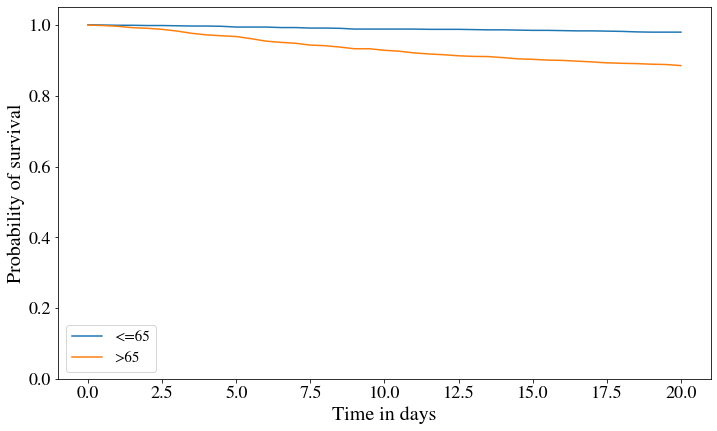

In [20]:

plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_age[columns[0]], df_age[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
#plt.savefig('Survival_analysis_Age_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()

# ADMISSIONS WITH DEAD PATIENT
dict_df_age = {}


int_days = 15

columns = ['time_days','<=65', '>65']
time = [i for i in np.linspace(0, int_days, int_days*2 +1)]
dict_df_age[columns[0]] = time

df_temp = df[(df['age']<=65) & (df['admission'].isin(list_mortal_admins ))]
ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[1]] = ls_age

df_temp = df[(df['age']>65) & (df['admission'].isin(list_mortal_admins ))]
ls_age  = [1 - (len(df_temp[df_temp['los']< t])/len(df_temp)) for t in time]
dict_df_age[columns[2]] = ls_age


df_age = pd.DataFrame(dict_df_age) 



plt.figure(figsize=(10,6))
for col in columns[1:]:
    plt.plot(df_age[columns[0]], df_age[col], label = col)
plt.ylabel('Probability of survival', fontsize = 20)
plt.xlabel('Time in days', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim((0.0,1.05))
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 15)
plt.savefig('Survival_analysis_Age_deceased_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()